In [46]:
m = 1
path = "clump_" + str(m)
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
    #continue # dont try to re-evaluate things if you already find a file
else:
    print ("Successfully created the directory %s" % path)
os.chdir(path)

# centre on the clumps
df_g[-1] = center_clump(df_g[-1], max_x[m], max_y[m]) # Gas
df_d[-1] = center_clump(df_d[-1], max_x[m], max_y[m]) # Disc
df_n[-1] = center_clump(df_n[-1], max_x[m], max_y[m]) # New

# Crop out a 100 pc box
g_clump = clump_crop(df_g[-1], 100)
d_clump = clump_crop(df_d[-1], 100)
n_clump = clump_crop(df_n[-1], 100)



g_mass = "{:e}".format(np.sum(g_clump.mass))
d_mass = "{:e}".format(np.sum(d_clump.mass))
n_mass = "{:e}".format(np.sum(n_clump.mass))

# End the analysis on the next try if the clump is too small
if np.sum(g_clump.mass) < 10**(6):
    end_sim = True

# Runs and plots time evolution
merge_timesteps(g_clump, d_clump, df_g, df_d)

# Run metal cals
g_clump = make_metals(g_clump)
d_clump = make_metals(d_clump)
n_clump = make_metals(n_clump)

chem_vis(g_clump, 'Fe_H', 'gas')
chem_vis(g_clump, 'z_metal', 'gas')

chem_vis(d_clump, 'Fe_H', 'disc')
chem_vis(d_clump, 'z_metal', 'disc')


Successfully created the directory clump_1


In [47]:
def centre_KDE(g_clump, i):
    ''' Use a KDE to estimate the central region of the clump 
        g_clump is the dataframe 
        i is the radii we will be searcing in (50 seems reasonable)
        returns the x, y, z positions of the central point '''
    g_clump_crop = g_clump.loc[(g_clump.y_scale<i)&(g_clump.y_scale>-i)& \
                           (g_clump.x_scale<i)&(g_clump.x_scale>-i)& \
                           (g_clump.z<i)&(g_clump.z>-i)]

    xyz = np.vstack([g_clump_crop.x_scale, g_clump_crop.y_scale, g_clump_crop.z])
    kde = stats.gaussian_kde(xyz, weights = g_clump_crop.mass, bw_method = 'silverman')
    density = kde(xyz)
    np.save("kde", density)

    max_density = np.argmax(density)
    max_dense_x = g_clump_crop.x_scale.iloc[max_density]
    max_dense_y = g_clump_crop.y_scale.iloc[max_density]
    max_dense_z = g_clump_crop.z.iloc[max_density]
    
    return max_dense_x, max_dense_y, max_dense_z
    
def load_kde():
    ''' Used when the KDE has already been run
        Has the same output as centre KDE'''
    
    density = np.load('kde.npy') # Load in the file
    
    max_density = np.argmax(density)
    max_dense_x = g_clump_crop.x_scale.iloc[max_density]
    max_dense_y = g_clump_crop.y_scale.iloc[max_density]
    max_dense_z = g_clump_crop.z.iloc[max_density]
    
    return max_dense_x, max_dense_y, max_dense_z

In [48]:
# Using a KDE to get the center point within the clump

if os.path.exists('kde.npy'):
    print('Loading KDE')
    max_dense_x, max_dense_y, max_dense_z = load_kde()
else:
    print('Generating KDE')
    max_dense_x, max_dense_y, max_dense_z = centre_KDE(g_clump, 50)

Generating KDE


In [49]:
# Pass max_dense_x - max_x[m] to the function
# Calculate a reference velosity to subtract off - g and d should have the same scaling!!!
def clump_scale(clump, max_dense_x, max_dense_y, max_dense_z, av_vx, av_vy, av_vz):
    clump = clump.assign(x_scale = clump.x - max_dense_x)
    clump = clump.assign(y_scale = clump.y - max_dense_y)
    clump = clump.assign(z_scale = clump.z - max_dense_z)
    clump = clump.assign(r_scale = np.power(clump.x_scale**2 + clump.y_scale**2 + clump.z_scale**2, 0.5))
    
    # subtract off mean velocity 
    clump = clump.assign(vx_scale = clump.vx + abs(av_vx))
    clump = clump.assign(vy_scale = clump.vy + abs(av_vy))
    clump = clump.assign(vz_scale = clump.vz + abs(av_vz))
    clump = clump.assign(v_abs = np.power(clump.vx_scale**2 + clump.vy_scale**2 + clump.vz_scale**2, 0.5))
    
    return clump

In [50]:
# assume disc stars are a better representation of the mean velosity of the clump
av_vx = np.mean(d_clump.vx)
av_vy = np.mean(d_clump.vy)
av_vz = np.mean(d_clump.vz)

In [51]:
g_clump = clump_scale(g_clump, max_dense_x - max_x[m], max_dense_y - max_y[m], max_dense_z, av_vx, av_vy, av_vz)
d_clump = clump_scale(d_clump, max_dense_x - max_x[m], max_dense_y - max_y[m], max_dense_z, av_vx, av_vy, av_vz)

In [52]:
# Scaling gas and disc values

g_clump = g_clump.assign(x_scale = g_clump.x - max_dense_x - max_x[m])
g_clump = g_clump.assign(y_scale = g_clump.y - max_dense_y - max_y[m])
g_clump = g_clump.assign(z_scale = g_clump.z - max_dense_z)
g_clump = g_clump.assign(r_scale = np.power(g_clump.x_scale**2 + g_clump.y_scale**2 + g_clump.z_scale**2, 0.5))

d_clump = d_clump.assign(x_scale = d_clump.x - max_dense_x - max_x[m])
d_clump = d_clump.assign(y_scale = d_clump.y - max_dense_y - max_y[m])
d_clump = d_clump.assign(z_scale = d_clump.z - max_dense_z)
d_clump = d_clump.assign(r_scale = np.power(d_clump.x_scale**2 + d_clump.y_scale**2 + d_clump.z_scale**2, 0.5))


g_clump = g_clump.assign(vx_scale = g_clump.vx + abs(np.mean(g_clump.vx)))
g_clump = g_clump.assign(vy_scale = g_clump.vy + abs(np.mean(g_clump.vy)))
g_clump = g_clump.assign(vz_scale = g_clump.vz + abs(np.mean(g_clump.vz)))
g_clump = g_clump.assign(v_abs = np.power(g_clump.vx_scale**2 + g_clump.vy_scale**2 + g_clump.vz_scale**2, 0.5))

d_clump = d_clump.assign(vx_scale = d_clump.vx + abs(np.mean(g_clump.vx)))
d_clump = d_clump.assign(vy_scale = d_clump.vy + abs(np.mean(g_clump.vy)))
d_clump = d_clump.assign(vz_scale = d_clump.vz + abs(np.mean(g_clump.vz)))
d_clump = d_clump.assign(v_abs = np.power(d_clump.vx_scale**2 + d_clump.vy_scale**2 + d_clump.vz_scale**2, 0.5))


In [53]:
def cum_freq_plot(res_g, res_d):

    x_g = res_g.lowerlimit + np.linspace(0, res_g.binsize*res_g.cumcount.size,
                                     res_g.cumcount.size)
    fig, ax = plt.subplots()
    plt.plot(x_g, np.log10(res_g.cumcount), label = 'GMC', color = 'skyblue')
    plt.plot(x_g, np.log10(res_d.cumcount), label = 'Disc', color = 'lightcoral')

    ax.set_xlabel(r'Radii (clump centre) (pc)')
    ax.set_ylabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
    ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
    plt.savefig("cumulative_density", bbox_inches='tight', dpi = 300)
    plt.show()

In [54]:
x_g = res_g.lowerlimit + np.linspace(0, res_g.binsize*res_g.cumcount.size,
                                     res_g.cumcount.size)

def half_mass_calcs(res, x):
    mass_at_half_rad = res.cumcount[-1]/2
    idx = (np.abs(res.cumcount - mass_at_half_rad)).argmin()
    return mass_at_half_rad, np.round(x[idx])


half_mass, radius = half_mass_calcs(res_g, x_g)
print(half_mass, radius)

23203800.0 65.0


In [55]:
mass_at_half_rad = res_d.cumcount[-1]/2

x_g = res_g.lowerlimit + np.linspace(0, res_g.binsize*res_g.cumcount.size,
                                     res_g.cumcount.size)

In [56]:
np.log10(mass_at_half_rad)
print('actual 1/2 mass radius ', np.log10(mass_at_half_rad))
idx = (np.abs(res_d.cumcount - mass_at_half_rad)).argmin()
print('closest val to 1/2 mass radius ', np.log10(res_g.cumcount[idx]))
np.round(x_g[idx])



actual 1/2 mass radius  6.824807343096031
closest val to 1/2 mass radius  7.5573977122108005


91.0

/Users/maddie/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys


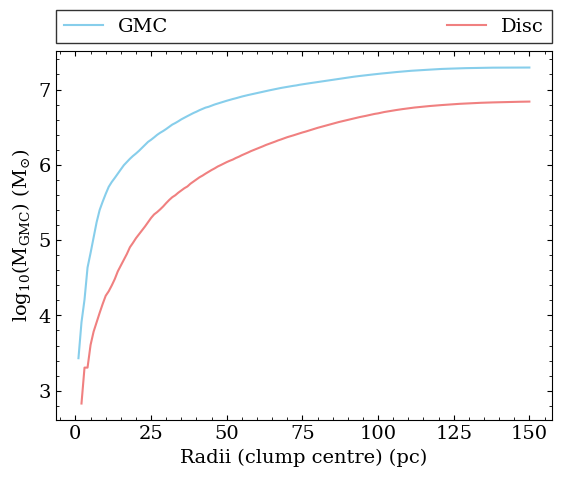

In [57]:
res_g = stats.cumfreq(g_clump.r_scale, weights = g_clump.mass, numbins=150, defaultreallimits=(1, 150))
res_d = stats.cumfreq(d_clump.r_scale, weights = d_clump.mass, numbins=150, defaultreallimits=(1, 150))
cum_freq_plot(res_g, res_d)

In [58]:
# Combining the two scaled arrays to calculate the cumulative mass
all_clump = pd.concat([g_clump, d_clump])

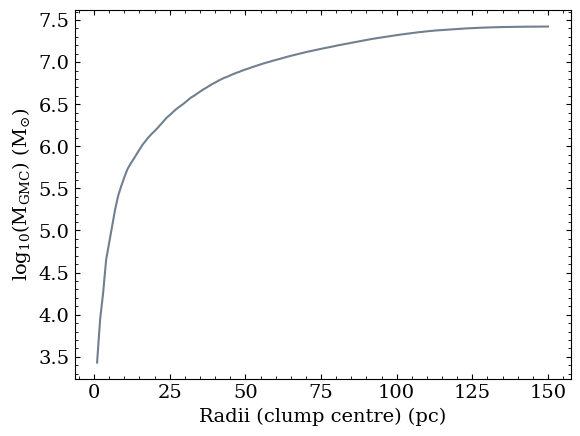

In [59]:
# Combining the two scaled arrays to calculate the cumulative mass
all_clump = pd.concat([g_clump, d_clump])

# Cumulative histogram 1 bin/pc

res = stats.cumfreq(all_clump.r_scale, weights = all_clump.mass, numbins=150, defaultreallimits=(1, 150))
x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,
                                 res.cumcount.size)
fig, ax = plt.subplots()
plt.plot(x, np.log10(res.cumcount), color = 'slategrey')
ax.set_xlabel(r'Radii (clump centre) (pc)')
ax.set_ylabel(r'$\rm{log}_{10} (\rm{M}_{\rm{GMC}}) \  (\rm{M}_{\odot})$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

In [60]:
G = 4.3e-3 # gravitational constant in pc Msun^-1 (km/s)^2
v_esc = np.power((2*res.cumcount * G)/x , 0.5) # formula for escape velocity

In [61]:
def kinematics_output(clump, file_name):

    i = 100
    cm1 = plt.cm.get_cmap('RdBu')
    cm2 = plt.cm.get_cmap('Purples')
    fig = plt.figure()
    
    clump_mean, _, _,_ = stats.binned_statistic_2d(clump.x_scale, clump.z_scale, 
                                               values = clump.vy_scale, statistic ='mean', bins = [i*2, i*2], range = [[-i, i], [-i, i]])

    clump_std, _, _,_ = stats.binned_statistic_2d(clump.x_scale, clump.z_scale, 
                                               values = clump.vy_scale, statistic ='std', bins = [i*2, i*2], range = [[-i, i], [-i, i]])


    clump_mean = np.nan_to_num(clump_mean, nan=0.0)
    clump_std  = np.nan_to_num(clump_std, nan=0.0)
    #counts,xbins,ybins = np.histogram2d(d_clump.x_scale, d_clump.z_scale, bins = 200, weights = d_clump.mass)


    clump_mean = gaussian_filter(clump_mean, sigma=3)
    clump_std  = gaussian_filter(clump_std, sigma=3)

    # make sure the colour bar is symmetrical
    v_limits = np.max([abs(np.min(clump_mean)),np.max(clump_mean)])


    gs = gridspec.GridSpec(1, 5, width_ratios=[1,0.05, 0.5, 1,0.05])  
    cbax1 = plt.subplot(gs[0,1])
    cbax2 = plt.subplot(gs[0,4])
    gamma = 0.1

    ax1 = plt.subplot(gs[0,0])
    ax2 = plt.subplot(gs[0,3])

    fig.set_size_inches(15,5)


    #vmin=-v_limits, vmax=v_limits,
    im1 = ax1.imshow(clump_mean.T, origin='lower', cmap=cm1, extent=[-i, i, -i, i], vmin = -v_limits, vmax = v_limits)
    im2 = ax2.imshow(clump_std.T, origin='lower', cmap=cm2, extent=[-i, i, -i, i])

    cb1 = Colorbar(ax = cbax1, mappable = im1)
    cb2 = Colorbar(ax = cbax2, mappable = im2)

    # make the contour plot
    mylevels=[1e3, 5e3, 1e4]
    #ax0.contour(counts.transpose(),mylevels,extent=[xbins.min(),xbins.max(),
    #    ybins.min(),ybins.max()],linewidths=1,colors='black',
    #    linestyles='solid')

    gs.update(left=0.05, right=0.95, bottom=0.08, top=0.93, wspace=0.0, hspace=0.0)   
    ax1.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax1.xaxis.set_minor_locator(AutoMinorLocator())
    ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.set_xlabel('X (pc)')
    ax1.set_ylabel('Z (pc)')

    ax2.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
    ax2.xaxis.set_minor_locator(AutoMinorLocator())
    ax2.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.set_xlabel('X (pc)')
    ax2.set_ylabel('Z (pc)')

    cb1.set_label(r'V$_y$(Kms$^{-1}$)')
    cb2.set_label(r'$\sigma_y$(Kms$^{-1}$)')
    plt.savefig(file_name, bbox_inches='tight', dpi = 300)

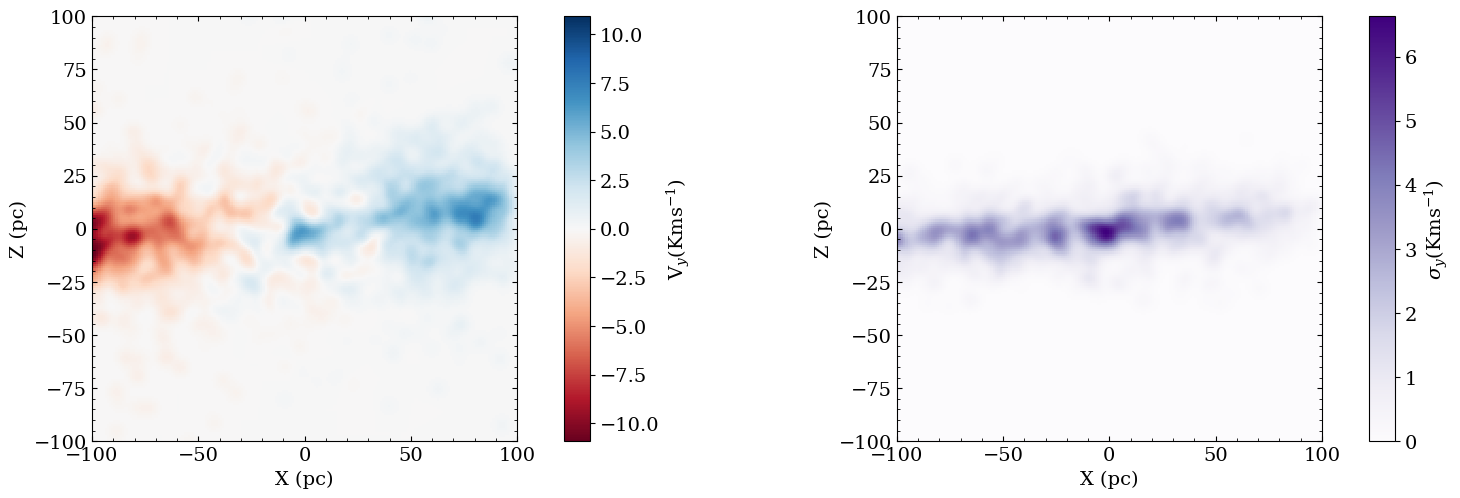

In [62]:
kinematics_output(g_clump, "rotation_map_gas")

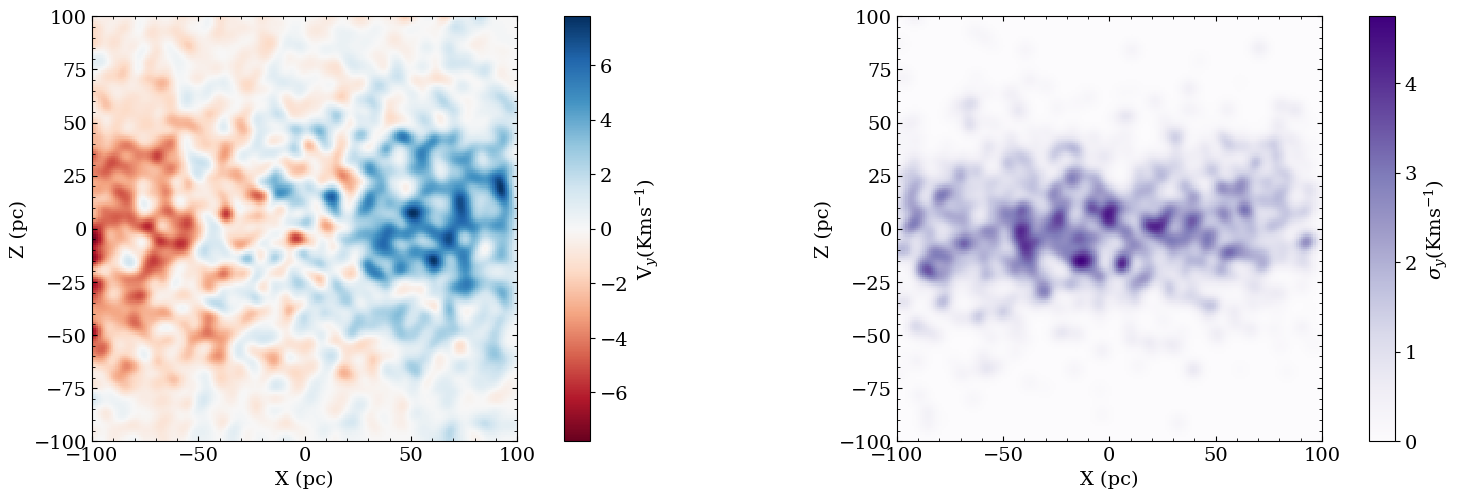

In [63]:
kinematics_output(d_clump, "rotation_map_disc")

In [ ]:
# Get average disc velocity per parsec radially
# Problems - not isotropic, if not the central clump, my be some net rotation that
# may need to be subtracted off


bin_means, bin_edges, binnumber = stats.binned_statistic(d_clump.r_scale , d_clump.v_abs, statistic='mean', 
                                                         range = (0, 150), bins = 150)
bin_count, bin_edges, binnumber = stats.binned_statistic(d_clump.r_scale , d_clump.v_abs, statistic='count', 
                                                         range = (0, 150), bins = 150)

bin_width = (bin_edges[1] - bin_edges[0])
bin_centers = bin_edges[1:] - bin_width/2 # [  0.5   1.5   2.5   3.5 ...

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(7,4)
plt.plot(bin_centers, bin_means, label = 'Average Disc Velocity', color = 'mediumaquamarine')
plt.plot(x, v_esc, label = 'Escape Velocity', color='thistle')
ax.set_xlabel(r'Radii (clump centre) (pc)')
ax.set_ylabel(r'Velocity $(\rm{kms}^{-1})$')
ax.set_xlim(0,150)
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=2, mode="expand", 
             borderaxespad=0., edgecolor='0', fancybox=False, frameon=True)
plt.show()

In [ ]:
def escapers(d_clump, v_esc, no_of_bins):
    ''' Returns the number and mass of stars which have a velocity 
        higher than the escape velocity for that particluar bin '''

    star_count = np.zeros(no_of_bins)
    star_mass_count = np.zeros(no_of_bins)
    for i in range(len(d_clump)):
        row = d_clump.iloc[i]
        #bin_rad = int(np.round(row.r_scale)) # its location to the nearest pc
        bin_rad = int(np.ceil(row.r_scale)) -1  # turn into an index

        if bin_rad > no_of_bins:
            continue

        if row.v_abs > v_esc[bin_rad]:
            star_count[bin_rad] += 1
            star_mass_count[bin_rad] += row.mass
            
    return star_count, star_mass_count

In [ ]:
star_count, star_mass_count = escapers(d_clump, v_esc, len(v_esc))

In [ ]:
print(np.sum(star_count))
print(np.sum(star_mass_count))

In [ ]:
fig, ax = plt.subplots()
plt.plot(bin_centers, star_count, label = 'Average Disc Velocity', color = 'slategrey')
#plt.plot(x, v_esc, label = 'Escape Velocity', color='thistle')
ax.set_xlabel(r'Radii (clump centre) (pc)')
ax.set_ylabel(r'Count')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.show()

In [ ]:
np.sum(star_count)/len(d_clump)

In [ ]:
total_escape = np.sum(star_count)/len(d_clump)

fig, ax = plt.subplots()
plt.plot(bin_centers, star_count/bin_count, label = 'Escaping Fraction', color = 'slategrey')
ax.set_xlabel(r'Radii (clump centre) (pc)')
ax.set_ylabel(r'$f_{escape}$')
ax.tick_params(direction='in', axis='both', which='both', bottom=True,top=True, left=True, right=True)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_xlim(0,150)
ax.set_ylim(0,1.05)
plt.show()

In [196]:
from sklearn.cluster import KMeans

In [197]:
def plot_kmeans(kmeans, X, n_clusters=1, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

In [232]:
from sklearn.manifold import TSNE

In [325]:
X = np.column_stack([g_clump.x_scale, g_clump.y_scale, g_clump.z_scale, g_clump.vx, g_clump.vy, g_clump.vz, g_clump.m_C, g_clump.m_N, g_clump.m_O, g_clump.m_Fe,
                            g_clump.m_Mg, g_clump.m_Ca, g_clump.m_Si, g_clump.m_S, g_clump.m_Ba, g_clump.d_C, g_clump.d_N, g_clump.d_O, g_clump.d_Fe,
                            g_clump.d_Mg, g_clump.d_Ca, g_clump.d_Si, g_clump.d_S, g_clump.d_Ba])

In [335]:
X_2d = TSNE(n_components=2, perplexity = 20, early_exaggeration = 30, learning_rate = 500).fit_transform(X)

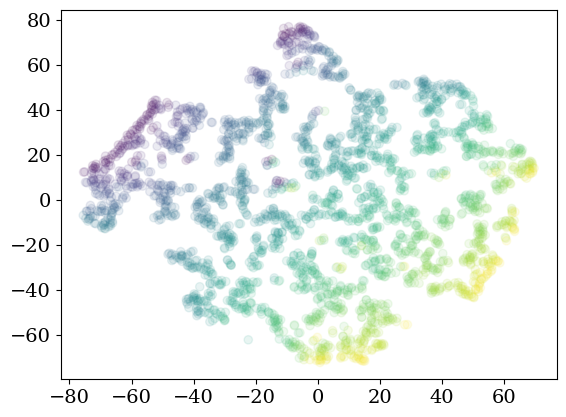

In [336]:
plt.scatter(X_2d[:,0], X_2d[:,1], c = g_clump.x_scale, alpha = 0.1)

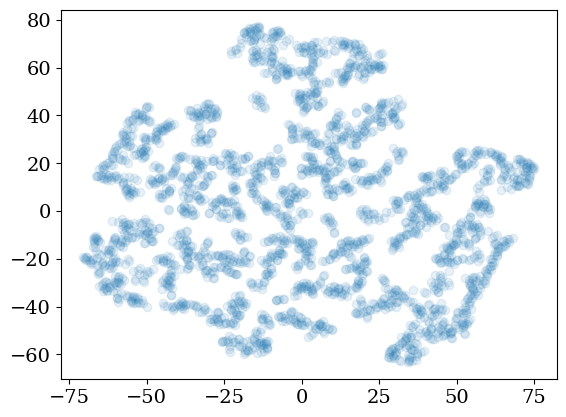

In [337]:
X = np.column_stack([g_clump.x_scale, g_clump.y_scale, g_clump.z_scale])
X_2d = TSNE(n_components=2, perplexity = 20, early_exaggeration = 30, learning_rate = 500).fit_transform(X)
plt.scatter(X_2d[:,0], X_2d[:,1], alpha = 0.1)

In [ ]:
## KDE plotting CODE

In [ ]:
xmin, xmax = min(g_clump.x_scale), max(g_clump.x_scale)
    ymin, ymax = min(g_clump.y_scale), max(g_clump.y_scale)


    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])

    r_Fe_H = np.vstack([g_clump.x_scale, g_clump.y_scale])
    kde = stats.gaussian_kde(r_Fe_H,  bw_method = 'silverman')

    f = np.reshape(kde(positions).T, xx.shape)